<a href="https://colab.research.google.com/github/maikejulie/DNN4Cli/blob/main/THOR/Step3/Step3_THOR_ESM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# THOR step 3

Applying the EnsembleMLP to detect the ocean regime in unseen models when training. Here we use the historical scenario of ESM4



More details in Sonnewald and Lguensat 2021

### Import libraries

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
##################
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input
###################
from pickle import load

this custom colormap will be helpful

In [31]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

Google Drive 

In [32]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [33]:
%cd /gdrive

/gdrive


load ECCO labels

In [47]:
ecco_label = np.transpose(np.load('kCluster6.npy'))
ecco_label[ecco_label==-1] = np.nan

# Use THOR on ESM data - Historical

In [34]:
ESMdata =np.load('esm4_historical1990to2009.npz')
ESMdata

Bathymetry ESM

In [35]:
BathmESM = ESMdata['depth']
BathmESM[BathmESM>1e19]=np.nan

lon/lat

In [36]:
lat = ESMdata['lat']
latDiff=1.111774765625000e+05

lonRoll = np.roll(ESMdata['lat'], axis=0, shift=-1)
Londiff = lonRoll - ESMdata['lat']

latY=np.gradient(lat, axis=0)*latDiff
lonX=np.abs(np.cos(lat*np.pi/180))*latDiff*Londiff

Coriolis

In [37]:
Omega=7.2921e-5
f=(2*Omega*np.sin(lat*np.pi/180))

Let's calculate curlTau for ESM

In [38]:
def grad(d,y,x):
    "Returns a three point derivative."
    grady=np.gradient(d, axis=0)/y
    gradx=np.gradient(d, axis=1)/x
    return grady, gradx

gradUx_y, gradUx_x = grad(ESMdata['tauu'],latY,lonX)
gradUy_y, gradUy_x = grad(ESMdata['tauv'],latY,lonX)

curlTauESM=(gradUy_x-gradUx_y)/1032

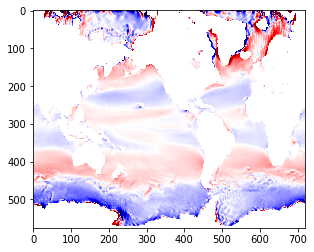

In [39]:
plt.imshow(np.flipud(curlTauESM), cmap='seismic')
plt.clim(-1e-9,1e-9)

## let's apply the NN on the ESM data

In [40]:
gradSSHESM_y, gradSSHESM_x = grad(ESMdata['ssh'],latY,lonX)
gradBathmESM_y, gradBathmESM_x = grad(BathmESM,latY,lonX)

In [41]:
missingdataindexESM = np.isnan(curlTauESM*ESMdata['ssh']*gradSSHESM_x*gradSSHESM_y*BathmESM*gradBathmESM_x*gradBathmESM_y)

In [42]:
TotalDatasetESM = np.stack((curlTauESM[~missingdataindexESM],
                         ESMdata['ssh'][~missingdataindexESM],
                         gradSSHESM_x[~missingdataindexESM],
                         gradSSHESM_y[~missingdataindexESM],
                         BathmESM[~missingdataindexESM],
                         gradBathmESM_x[~missingdataindexESM],
                         gradBathmESM_y[~missingdataindexESM],
                         f[~missingdataindexESM]),1)

TotalDatasetESM.shape

(255798, 8)

In [43]:
scaler = load(open('scaler_v1.pkl', 'rb'))
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [44]:
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [45]:
datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDatasetESM.shape[0],6))

for i in range(50):
  print(i)
  I1 = Input(shape=(8,)) 
  h1 = Dense(24, activation='tanh')(I1)
  h1 = Dense(24, activation='tanh')(h1)
  h1 = Dense(16, activation='tanh')(h1)
  h1 = Dense(16, activation='tanh')(h1)
  Output = Dense(6, activation='softmax')(h1)
  vanillamodel = Model(I1, Output)
  vanillamodel.load_weights('My Drive/colabwithMaike/closeThebudget/ManyNN/vanillamodel_'+str(i)+'.h5')
  datapredicted = vanillamodel.predict(scaler.transform(TotalDatasetESM))
  datapredicted_results_vanilla_ensemble[i,...] = datapredicted

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [46]:
datapredicted_results_ESM = np.nan * np.zeros(ESMdata['ssh'].shape)
datapredicted_results_ESM[~missingdataindexESM] = np.argmax(np.mean(datapredicted_results_vanilla_ensemble,0), 1)

Text(0.5, 1.0, 'Ground truth')

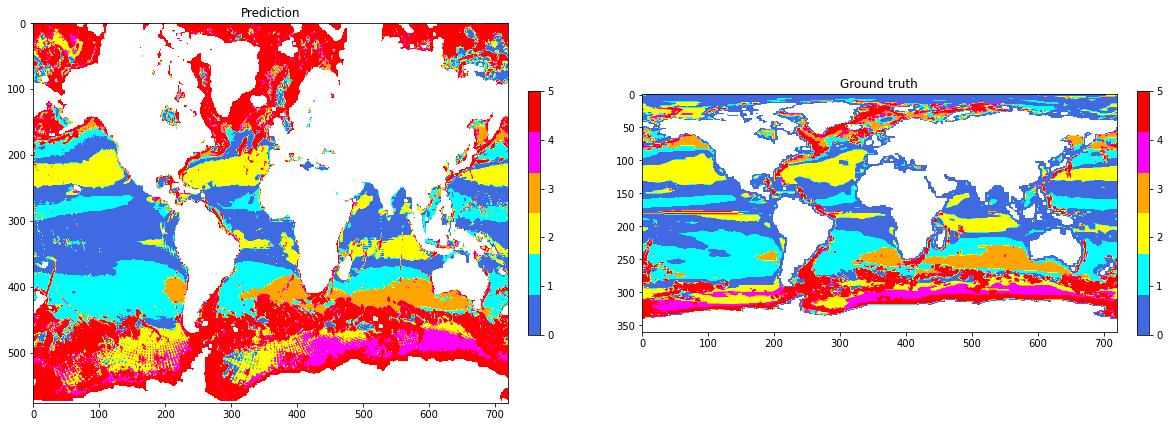

In [48]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_ESM[::-1,np.roll(range(720),500)], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('Prediction')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('Ground truth')